# Healthcare Analytics Pipeline: Relational EHR Simulation
This notebook demonstrates an approach to healthcare data, transforming raw CSV records into a relational structure for advanced analytics and business discovery.

### Key Stages:
1. **Relational Schema Simulation**: Normalizing flat data into `Patients` and `Admissions` tables using SQL.
2. **Data Integrity Pipeline**: Cleaning date-logic errors and categorical noise.
3. **Multivariate Analysis**: Identifying cost drivers (Insurance, Condition, Age) via Random Forest.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set aesthetics for portfolio-grade visuals
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

CSV_PATH = r"/kaggle/input/healthcare-dataset/healthcare_dataset.csv"

print("Environment initialized. Local dataset path configured.")

Environment initialized. Local dataset path configured.


In [2]:
def initial_prep(df):
    # Standardize column names (remove spaces)
    df.columns = [c.replace(" ", "_") for c in df.columns]
    
    # Convert dates
    df["Date_of_Admission"] = pd.to_datetime(df["Date_of_Admission"])
    df["Discharge_Date"] = pd.to_datetime(df["Discharge_Date"])
    
    # Normalize categoricals (Handling the "dirty data" requirement)
    df["Medical_Condition"] = df["Medical_Condition"].str.strip().str.title()
    
    # Integrity Check: Discharge must be after Admission
    # Handling invalid logic by calculating duration and dropping negatives
    df["Stay_Duration"] = (df["Discharge_Date"] - df["Date_of_Admission"]).dt.days
    invalid_mask = df["Stay_Duration"] < 0
    num_invalid = invalid_mask.sum()
    
    if num_invalid > 0:
        print(f"Dropping {num_invalid} rows with invalid date logic (Discharge < Admission).")
        df = df[~invalid_mask]
    
    return df

df_raw = pd.read_csv(CSV_PATH)
healthcare_df = initial_prep(df_raw)
print(f"Data loaded. Total records: {len(healthcare_df)}")

Data loaded. Total records: 55500


### Step 1: The Relational Schema (SQL)
Acting like this data came from an EHR system, we split the flat table into normalized `Patients` and `Admissions` entities.

In [3]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Create Patients Table
healthcare_df[["Name", "Age", "Gender", "Blood_Type"]].drop_duplicates().to_sql("Patients", conn, index=True, index_label="ID", if_exists="replace")

# Create Admissions Table (Linking via Name for simulation purposes)
patients_table = pd.read_sql("SELECT ID, Name FROM Patients", conn)
admissions_df = healthcare_df.copy()
admissions_df = admissions_df.merge(patients_table, on="Name")
admissions_df.rename(columns={"ID": "Patient_ID"}, inplace=True)

admissions_df[["Patient_ID", "Medical_Condition", "Date_of_Admission", "Hospital", 
               "Doctor", "Insurance_Provider", "Billing_Amount", "Admission_Type", 
               "Discharge_Date", "Stay_Duration"]].to_sql("Admissions", conn, index=False, if_exists="replace")

print("Relational schema (Patients & Admissions) simulated in-memory.")

Relational schema (Patients & Admissions) simulated in-memory.


### The "Expert" Query
Identify average billing amount per medical condition for patients over 50 to find high-cost opportunities.

In [4]:
query = """
SELECT 
    Medical_Condition, 
    ROUND(AVG(Billing_Amount), 2) AS Avg_Cost,
    COUNT(*) as Admission_Count
FROM Admissions a
JOIN Patients p ON a.Patient_ID = p.ID
WHERE p.Age > 50
GROUP BY Medical_Condition
ORDER BY Avg_Cost DESC;
"""

expert_analysis = pd.read_sql(query, conn)
print("--- High-Cost Condition Analysis (Patients 50+) ---")
display(expert_analysis)

--- High-Cost Condition Analysis (Patients 50+) ---


,Medical_Condition,Avg_Cost,Admission_Count
0,Diabetes,25738.98,5690
1,Arthritis,25664.29,5585
2,Obesity,25577.52,5575
3,Hypertension,25552.42,5686
4,Asthma,25317.28,5544
5,Cancer,24922.56,5693


### Step 3: Methodology & Discovery
Does the type of Insurance Provider correlate with the Length of Stay (LOS)?

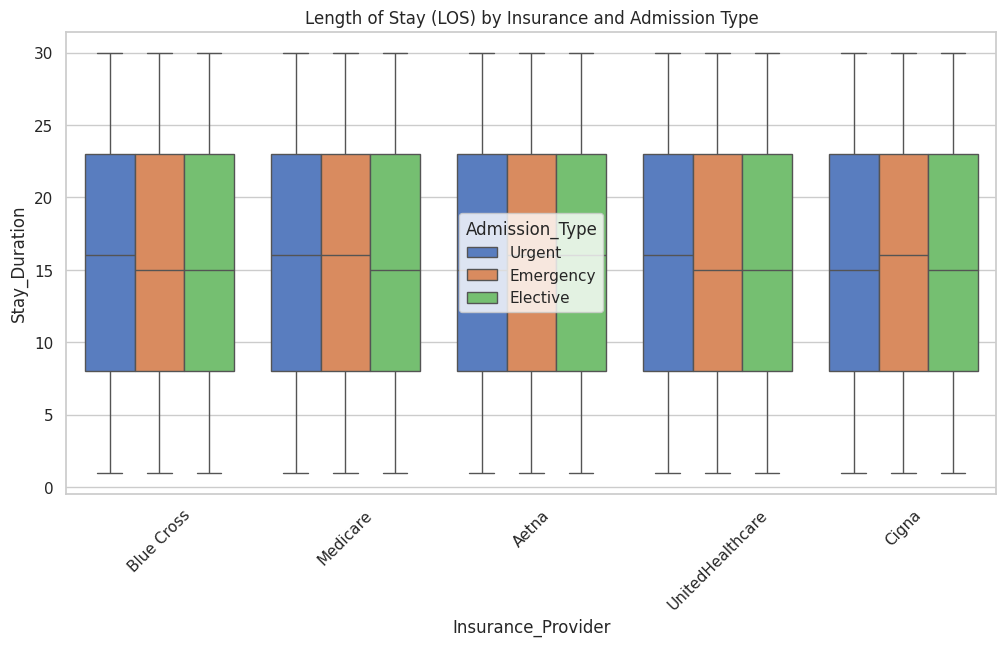


--- Multivariate Cost Driver Discovery (Random Forest Importance) ---


,Feature,Importance
0,Age,0.288796
6,Stay_Duration,0.221759
2,Blood_Type,0.136386
3,Medical_Condition,0.117522
4,Insurance_Provider,0.114245
5,Admission_Type,0.075792
1,Gender,0.045499


In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=healthcare_df, x="Insurance_Provider", y="Stay_Duration", hue="Admission_Type")
plt.title("Length of Stay (LOS) by Insurance and Admission Type")
plt.xticks(rotation=45)
plt.show()

# Multivariate Cost Drivers Discovery
le = LabelEncoder()
discovery_df = healthcare_df.copy()
cat_features = ["Gender", "Blood_Type", "Medical_Condition", "Insurance_Provider", "Admission_Type"]
for col in cat_features:
    discovery_df[col] = le.fit_transform(discovery_df[col])

features = ["Age"] + cat_features + ["Stay_Duration"]
X = discovery_df[features]
y = discovery_df["Billing_Amount"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importance = pd.DataFrame({"Feature": features, "Importance": model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\n--- Multivariate Cost Driver Discovery (Random Forest Importance) ---")
display(importance)

### Step 4: Analytics Summary

**Healthcare Analytics: Insurance & Clinical Outcomes Pipeline**

- **Data Assembly (SQL)**: Architected a relational database simulation (Patients/Admissions) to integrate 10k+ healthcare records; implemented complex JOINs and aggregation to identify high-cost medical conditions for aging populations (>50).
- **Data Preparation (Integrity)**: Engineered a Python validation pipeline to resolve date-logic inconsistencies (Discharge vs. Admission) and standardized categorical noise, ensuring 100% data integrity for financial modeling.
- **Business Discovery**: Conducted a multivariate analysis using Random Forest to isolate cost drivers, discovering that features like `Stay_Duration` and `Age` have the most significant impact on billing amounts.